<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Authors:_ Joseph Nelson (DC), Boom Devahastin Na Ayudhya (NYC), Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
print(pd.__version__)

2.2.0


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from statsmodels.tsa.arima_model import ARIMA, ARMA, AR

# Auto ARIMA imports
import pmdarima as pm # to do Auto ARIMA
from pmdarima.arima import ADFTest # to perform ADF test 
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [7]:
data.index.dtype

dtype('O')

In [8]:
data.index = pd.to_datetime(data.index)
data.index.dtype

dtype('<M8[ns]')

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [9]:
store_1 = data[data['Store']==1]
store_1

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False
...,...,...,...,...
2012-08-31,1,99,20.06,False
2012-09-07,1,99,0.05,True
2012-09-14,1,99,0.03,False


In [10]:
Weekly_Sales = store_1.groupby(store_1.index)['Weekly_Sales'].sum()
Weekly_Sales = pd.DataFrame(Weekly_Sales)
Weekly_Sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

In [11]:
# Let's define a function to plot the temperature over time
def plot_series(df, col, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
               
    # Generate a line plot of the column name.
    # You only have to specify what goes on y-axis, since our index will auto be taken as the datetime index in matplotlib & represented on x-axis.
    plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

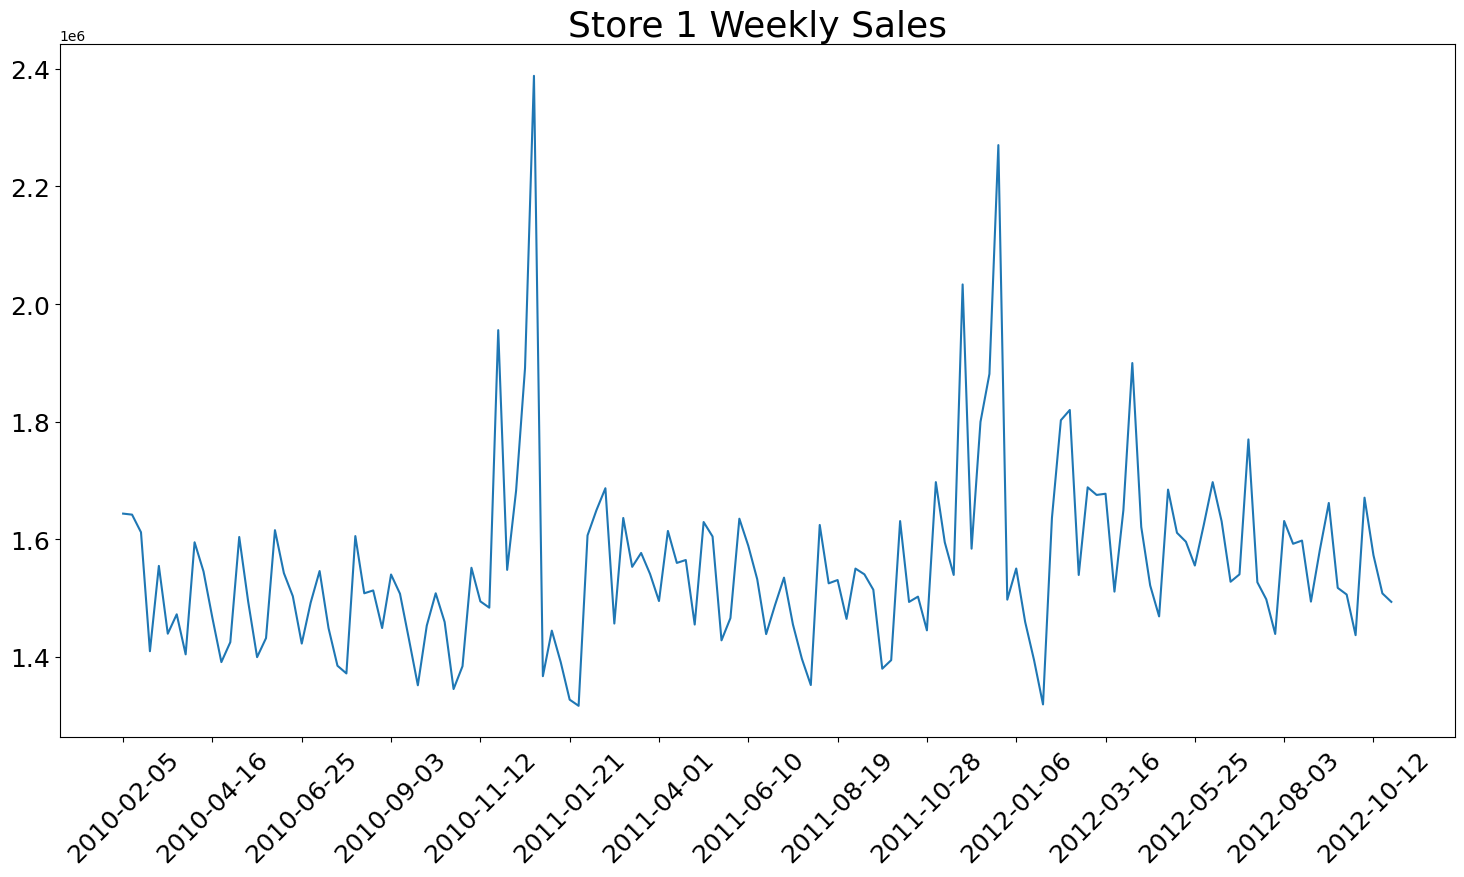

In [12]:
plot_series(Weekly_Sales, 'Weekly_Sales', title='Store 1 Weekly Sales', steps = 10)
plt.xticks(rotation=45);

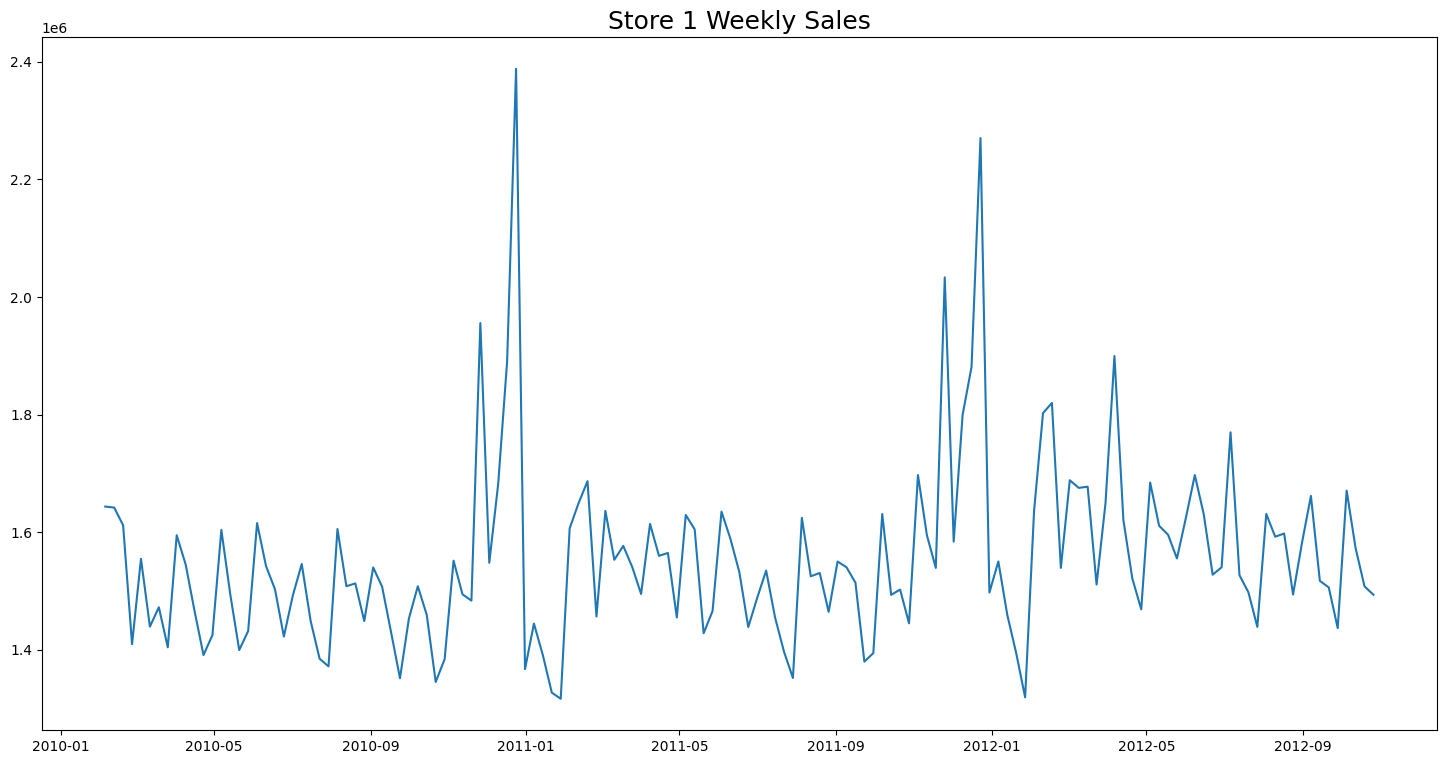

In [13]:
plt.figure(figsize=(18,9))
plt.plot(Weekly_Sales['Weekly_Sales'])
plt.title('Store 1 Weekly Sales', fontsize=18)
plt.show()

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

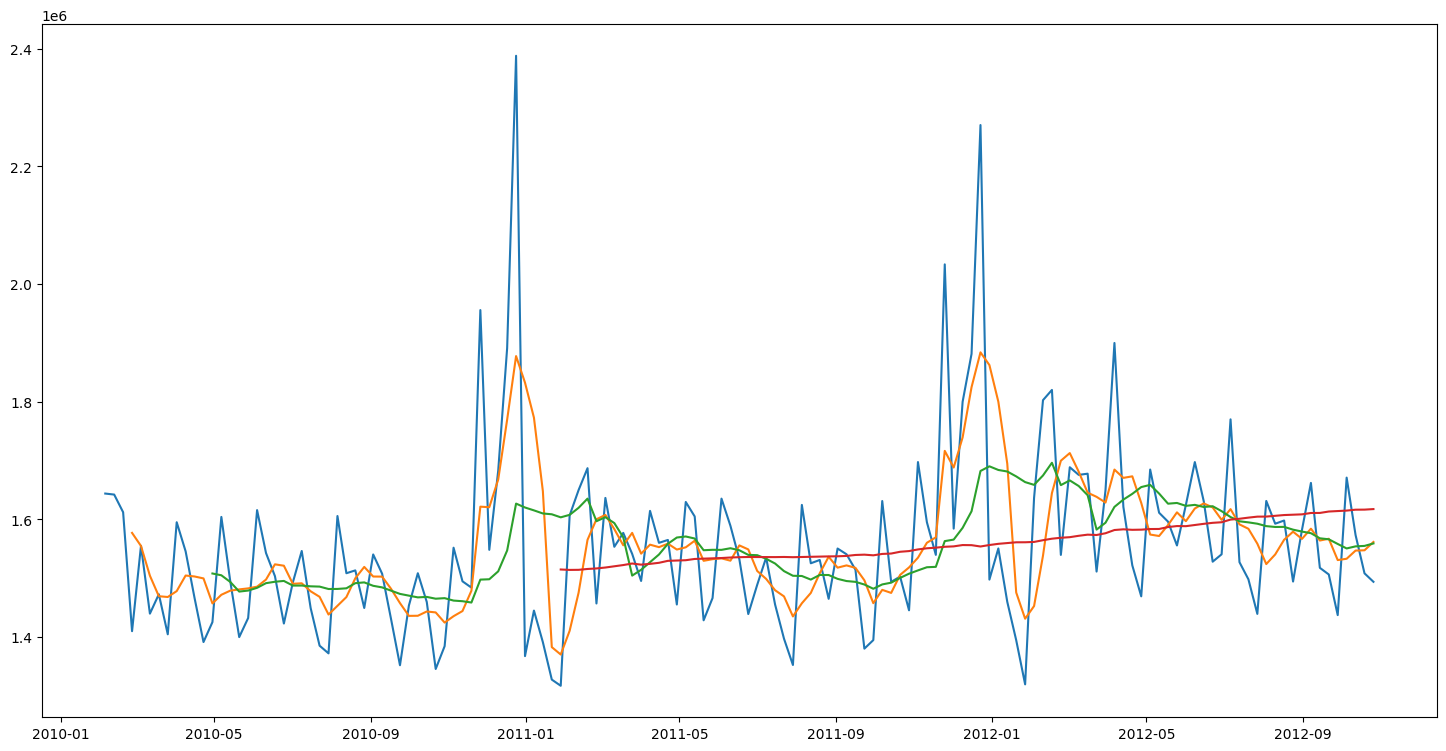

In [14]:
plt.figure(figsize=(18,9))
plt.plot(Weekly_Sales['Weekly_Sales'], label='Weekly Sales')
plt.plot(Weekly_Sales['Weekly_Sales'].rolling(4).mean(), label = 'Monthly')
plt.plot(Weekly_Sales['Weekly_Sales'].rolling(13).mean(), label = 'Quaterly')
plt.plot(Weekly_Sales['Weekly_Sales'].rolling(52).mean(), label = 'Annually')
plt.show()

**2c. What can you say about trends in the data based on the rolling mean plot above?**

*Answer:*  
Higher k makes the curve more bias. We also lose earlier data.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

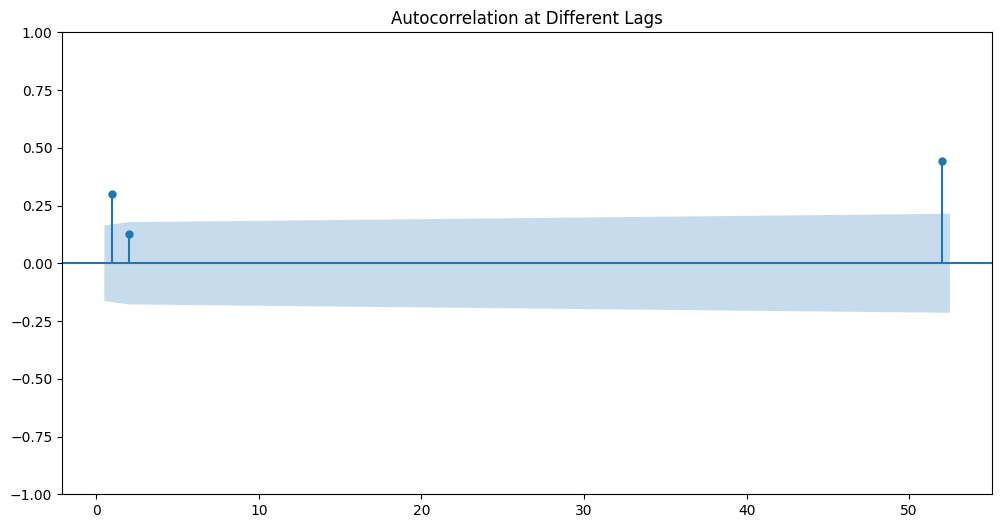

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(Weekly_Sales['Weekly_Sales'], lags=[1, 2, 52], ax=ax, title="Autocorrelation at Different Lags")
plt.show()

**3b. What can you say about the series based on these autocorrelations?**

Answer:  
52 week lag has the 95% confidence highest positive autocorrelation. Means seasonal patterns in the data where sales in the same week across different years tend to be similar.

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

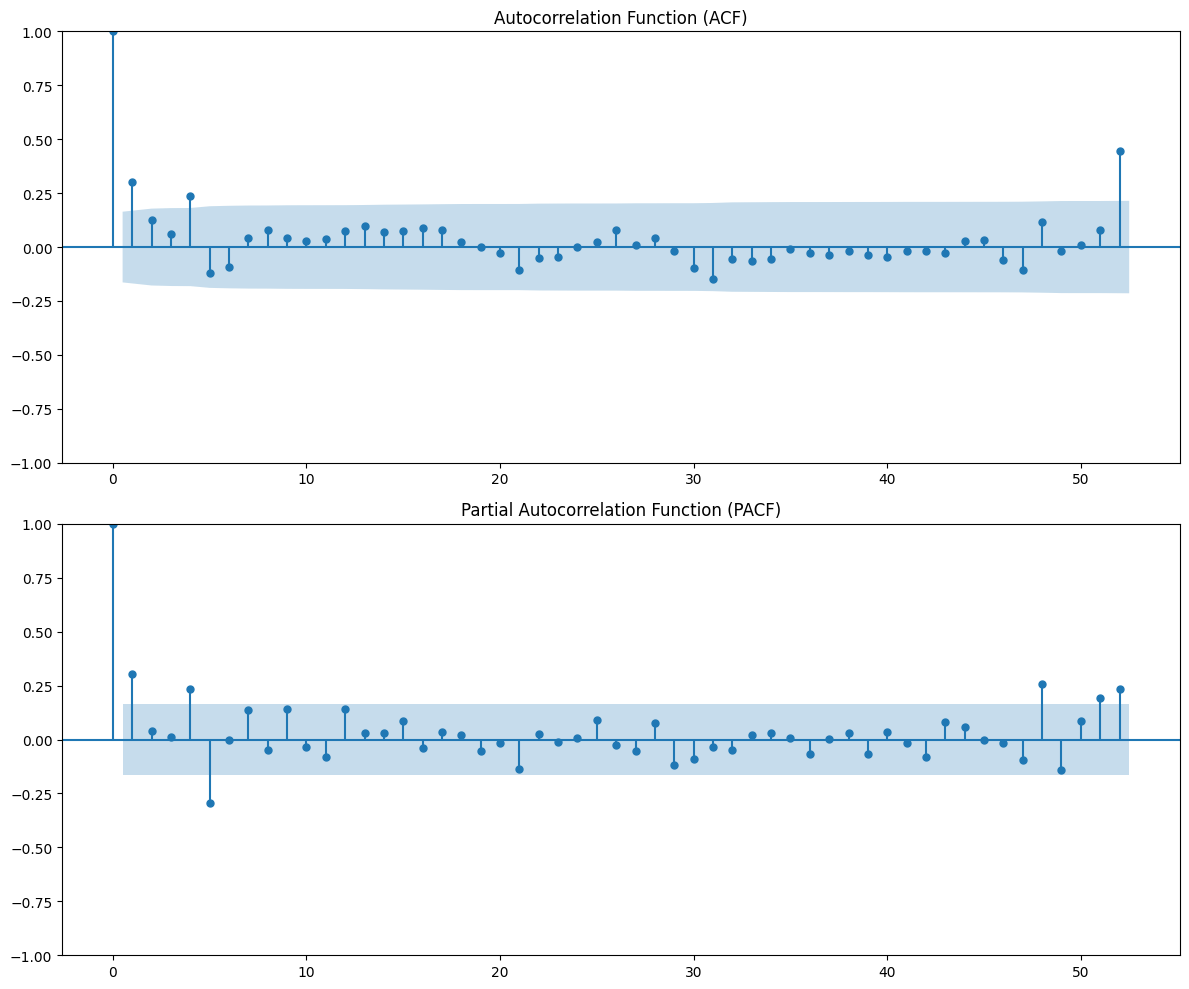

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(Weekly_Sales['Weekly_Sales'].dropna(), lags=52, ax=axes[0], title='Autocorrelation Function (ACF)')

plot_pacf(Weekly_Sales['Weekly_Sales'], lags=52, ax=axes[1], title='Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer:  
ACF:  
High spike at the 52 week lag. Suggest strong yearly seasonality in the data.

PACF:  
High values at lag 1,5 and 48. Suggest presence of seasonality.

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer:  
ACF:  
Gradual decrease autocorrelation across the lags and spike every 52 weeks shows presence both short term dependencies and long term patterns.

PACF:  
Sharp drop after the first lag suggests that autoregressive term of order 1 might be appropriate for model.

Model:  
SARIMA because there's seasonal pattern every 52 weeks.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [17]:
n_total = len(Weekly_Sales)
n_train = int(n_total*0.75)

train = Weekly_Sales.iloc[:n_train,0]

test = Weekly_Sales.iloc[n_train:,0]

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. In each section, we will add additional ARIMA parameters in an effort to improve our modeling. Note that sometimes the model you attempt is not effective or the best -- try the BONUS sections below to see other approaches to modeling this dataset!

- Note that this is the same thing as an `ARIMA(1,0,0)` model.
- Pass in the Weekly Sales as an `ndarray`, not a `Series`.
- Pass in the training index using the ARIMA `dates` parameter.

**6a. Instantiate and fit an `AR(1)` model.**

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
ar1_model = ARIMA(train, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), freq='W-FRI')

In [20]:
ar1_fitted_model = ar1_model.fit()

In [21]:
ar1_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1434.664
Date:                Sun, 28 Apr 2024   AIC                           2875.329
Time:                        17:54:33   BIC                           2883.347
Sample:                    02-05-2010   HQIC                          2878.579
                         - 02-17-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   2.74e+04     56.276      0.000    1.49e+06     1.6e+06
ar.L1          0.3147      0.056      5.638      0.000       0.205       0.424
sigma2      2.605e+10      0.216    1.2e+11      0.000    2.61e+10    2.61e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               186.21
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               4.45   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+26. Standard errors may be unstable.
"""

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [22]:
from sklearn.metrics import mean_squared_error

ar1_train_predictions = ar1_fitted_model.predict(start=0, end=len(train)-1)
ar1_test_predictions = ar1_fitted_model.predict(start=len(train), end=len(train) + len(test) - 1)

In [23]:
mse_train = mean_squared_error(train, ar1_train_predictions)
mse_test = mean_squared_error(test, ar1_test_predictions)

mse_train, mse_test

(25903503058.315876, 11108604490.663338)

**6c. How effective do you think this `AR(1)` model is?**

Answer:  
MSE is very hight means high error.
This model is not effective

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

In [24]:
ar1_train_residuals = train - ar1_train_predictions
ar1_test_residuals = test - ar1_test_predictions

# Combine training and test residuals into a single series for plotting, aligning with their respective dates
ar1_combined_residuals = pd.concat([ar1_train_residuals, pd.Series(ar1_test_residuals, index=test.index)], axis=0)


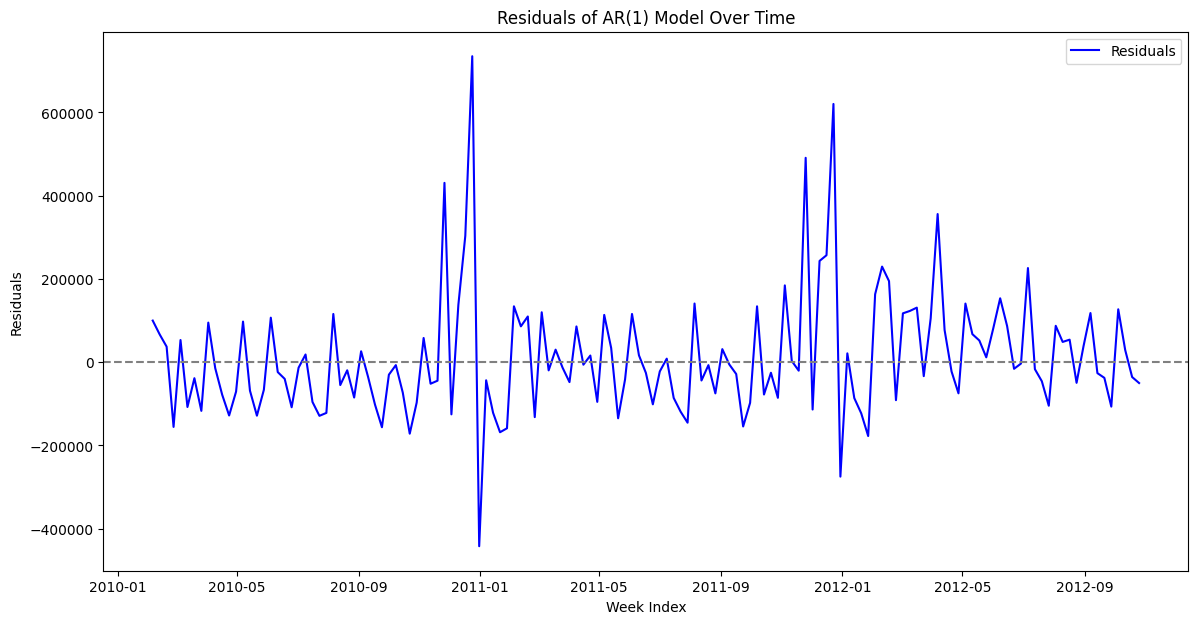

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(ar1_combined_residuals.index, ar1_combined_residuals, label='Residuals', color='blue')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Residuals of AR(1) Model Over Time')
plt.xlabel('Week Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer:  
There're spikes/variances in 2011-01 and 2012-01, means model is not effective during those times

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [26]:
ar2_model = ARIMA(train, order=(2, 0, 0), seasonal_order=(0, 0, 0, 0), freq='W-FRI')
ar2_fitted_model = ar2_model.fit()
ar2_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1434.487
Date:                Sun, 28 Apr 2024   AIC                           2876.974
Time:                        17:54:33   BIC                           2887.665
Sample:                    02-05-2010   HQIC                          2881.308
                         - 02-17-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   2.94e+04     52.559      0.000    1.49e+06     1.6e+06
ar.L1          0.2973      0.082      3.647      0.000       0.138       0.457
ar.L2          0.0589      0.138      0.426      0.670      -0.212       0.330
sigma2      2.617e+10      0.240   1.09e+11      0.000    2.62e+10    2.62e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.37
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.38   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+25. Standard errors may be unstable.
"""

In [27]:
ar2_train_predictions = ar2_fitted_model.predict(start=0, end=len(train)-1)
ar2_test_predictions = ar2_fitted_model.predict(start=len(train), end=len(train) + len(test) - 1)

In [28]:
mse_train = mean_squared_error(train, ar2_train_predictions)
mse_test = mean_squared_error(test, ar2_test_predictions)

mse_train, mse_test

(25814337771.776455, 10932762249.869028)

In [29]:
ar2_train_residuals = train - ar2_train_predictions
ar2_test_residuals = test - ar2_test_predictions

# Combine training and test residuals into a single series for plotting, aligning with their respective dates
ar2_combined_residuals = pd.concat([ar2_train_residuals, pd.Series(ar2_test_residuals, index=test.index)], axis=0)


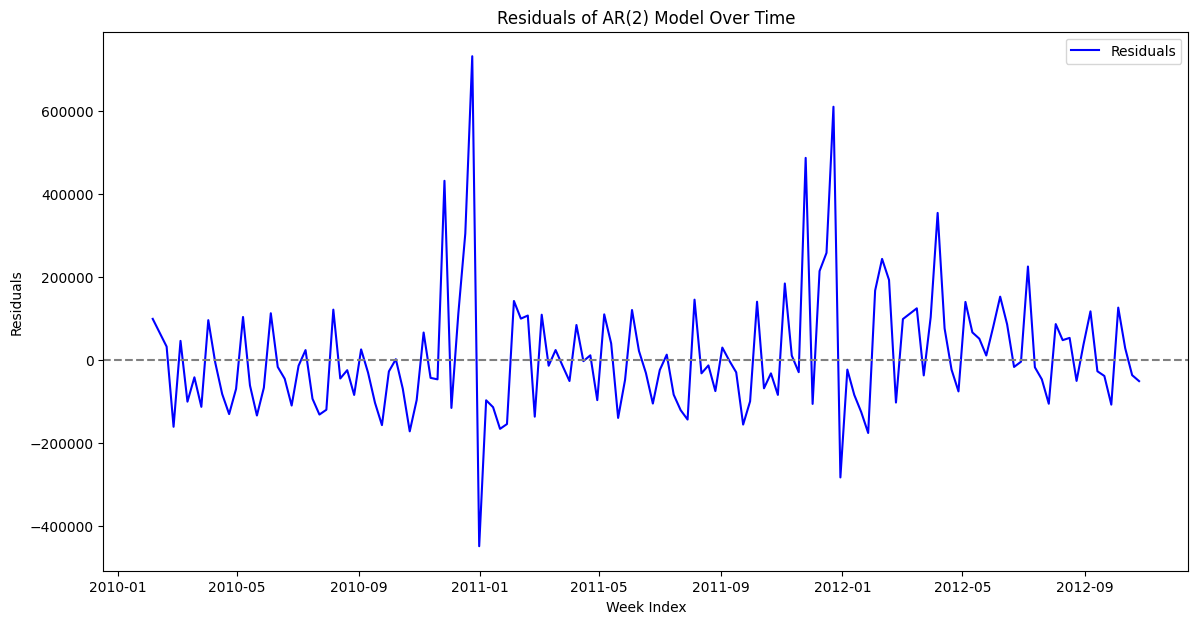

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(ar1_combined_residuals.index, ar2_combined_residuals, label='Residuals', color='blue')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Residuals of AR(2) Model Over Time')
plt.xlabel('Week Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

**8b. How did your results change?**

Answer:  
Slightly better but still not an effective model.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [31]:
arma2_model = ARIMA(train, order=(2, 0, 2), seasonal_order=(0, 0, 0, 0), freq='W-FRI')
arma2_fitted_model = arma2_model.fit()
arma2_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1426.207
Date:                Sun, 28 Apr 2024   AIC                           2864.414
Time:                        17:54:33   BIC                           2880.451
Sample:                    02-05-2010   HQIC                          2870.915
                         - 02-17-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   2.57e+04     60.151      0.000    1.49e+06    1.59e+06
ar.L1         -1.0337      0.081    -12.737      0.000      -1.193      -0.875
ar.L2         -0.4670      0.077     -6.039      0.000      -0.619      -0.315
ma.L1          1.4500      0.072     20.119      0.000       1.309       1.591
ma.L2          0.9766      0.089     10.925      0.000       0.801       1.152
sigma2      2.389e+10      0.097   2.45e+11      0.000    2.39e+10    2.39e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                76.50
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               4.55   Skew:                             1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.65e+31. Standard errors may be unstable.
"""

In [32]:
arma2_train_predictions = arma2_fitted_model.predict(start=0, end=len(train)-1)
arma2_test_predictions = arma2_fitted_model.predict(start=len(train), end=len(train) + len(test) - 1)

In [33]:
mse_train = mean_squared_error(train, arma2_train_predictions)
mse_test = mean_squared_error(test, arma2_test_predictions)

mse_train, mse_test

(21601543323.64593, 11047421610.653723)

In [34]:
arma2_train_residuals = train - arma2_train_predictions
arma2_test_residuals = test - arma2_test_predictions

# Combine training and test residuals into a single series for plotting, aligning with their respective dates
arma2_combined_residuals = pd.concat([arma2_train_residuals, pd.Series(arma2_test_residuals, index=test.index)], axis=0)


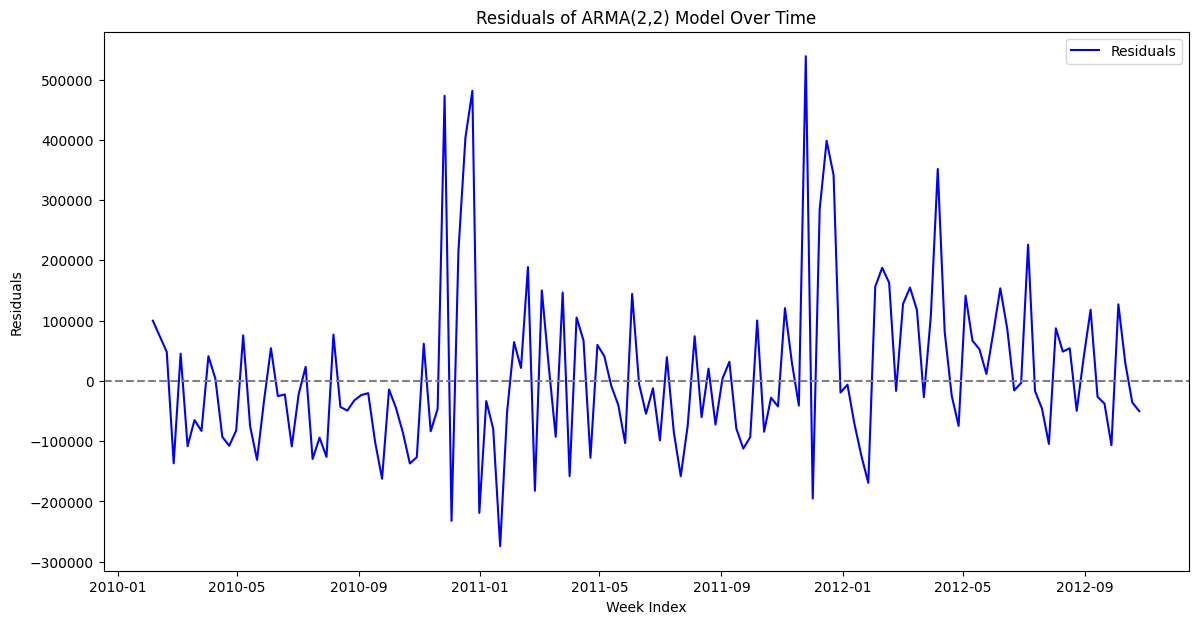

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(ar1_combined_residuals.index, arma2_combined_residuals, label='Residuals', color='blue')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Residuals of ARMA(2,2) Model Over Time')
plt.xlabel('Week Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer:  
Better, lower residuals but still not effective

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [36]:
# Augmented Dickey-Fuller test on our original monthly data as that was ambiguous to confirm stationarity
adf_test = ADFTest(alpha = 0.05) # instantiate ADF test with setting the threshold for p-value to accept/reject null hypothesis

# ADF test run using this function to tell should the df.diff() be called or not on the data passed
adf_test.should_diff(Weekly_Sales['Weekly_Sales']) 

(0.01, False)

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer:  
We do not need dif(). p-value is 0.001, we can reject null hypothesis and confirm that data is stationary. 

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [37]:
Weekly_Sales['Total_Weekly_Sales'] = Weekly_Sales['Weekly_Sales']
Weekly_Sales.drop(columns=['Weekly_Sales'], inplace=True)
Weekly_Sales.head()

,Total_Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [38]:
Weekly_Sales['Differenced_1'] = Weekly_Sales['Total_Weekly_Sales'].diff(periods=1)
Weekly_Sales['Differenced_2'] = Weekly_Sales['Total_Weekly_Sales'].diff(periods=2)
Weekly_Sales['Differenced_3'] = Weekly_Sales['Total_Weekly_Sales'].diff(periods=3)
Weekly_Sales['Differenced_4'] = Weekly_Sales['Total_Weekly_Sales'].diff(periods=4)

Weekly_Sales.head()

,Total_Weekly_Sales,Differenced_1,Differenced_2,Differenced_3,Differenced_4
Date,,,,,
2010-02-05,1643690.90,NaN,NaN,NaN,NaN
2010-02-12,1641957.44,-1733.46,NaN,NaN,NaN
2010-02-19,1611968.17,-29989.27,-31722.73,NaN,NaN
2010-02-26,1409727.59,-202240.58,-232229.85,-233963.31,NaN
2010-03-05,1554806.68,145079.09,-57161.49,-87150.76,-88884.22


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [39]:
columns_to_test = ['Differenced_1', 'Differenced_2', 'Differenced_3', 'Differenced_4']

for col in columns_to_test:
    # Augmented Dickey-Fuller test on our original monthly data as that was ambiguous to confirm stationarity
    adf_test = ADFTest(alpha = 0.05) # instantiate ADF test with setting the threshold for p-value to accept/reject null hypothesis

    # ADF test run using this function to tell should the df.diff() be called or not on the data passed
    print(adf_test.should_diff(Weekly_Sales.dropna()[col])) 

(0.01, False)
(0.01, False)
(0.01, False)
(0.01, False)


**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer:  
All is stationary, we can use original data

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer:  
Maybe not because it's already stationary. The issue is the model doesn't detect seasonality.

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [40]:
arima_model = ARIMA(train, order=(2, 1, 2))
arima_fitted_model = arima_model.fit()
arima_fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1429.564
Date:                Sun, 28 Apr 2024   AIC                           2869.129
Time:                        17:54:34   BIC                           2882.446
Sample:                    02-05-2010   HQIC                          2874.526
                         - 02-17-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5207      0.094     -5.517      0.000      -0.706      -0.336
ar.L2          0.4792      0.093      5.173      0.000       0.298       0.661
ma.L1          0.0715      0.117      0.613      0.540      -0.157       0.300
ma.L2         -0.9260      0.097     -9.550      0.000      -1.116      -0.736
sigma2      3.207e+10   4.61e-12   6.95e+21      0.000    3.21e+10    3.21e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                41.05
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.37
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+37. Standard errors may be unstable.
"""

In [41]:
arima_train_predictions = arima_fitted_model.predict(start=0, end=len(train)-1)
arima_test_predictions = arima_fitted_model.predict(start=len(train), end=len(train) + len(test) - 1)

In [42]:
mse_train = mean_squared_error(train, arima_train_predictions)
mse_test = mean_squared_error(test, arima_test_predictions)

mse_train, mse_test

(55427468005.95583, 11862708001.389473)

In [43]:
arima_train_residuals = train - arima_train_predictions
arima_test_residuals = test - arima_test_predictions

# Combine training and test residuals into a single series for plotting, aligning with their respective dates
arima_combined_residuals = pd.concat([arima_train_residuals, pd.Series(arima_test_residuals, index=test.index)], axis=0)


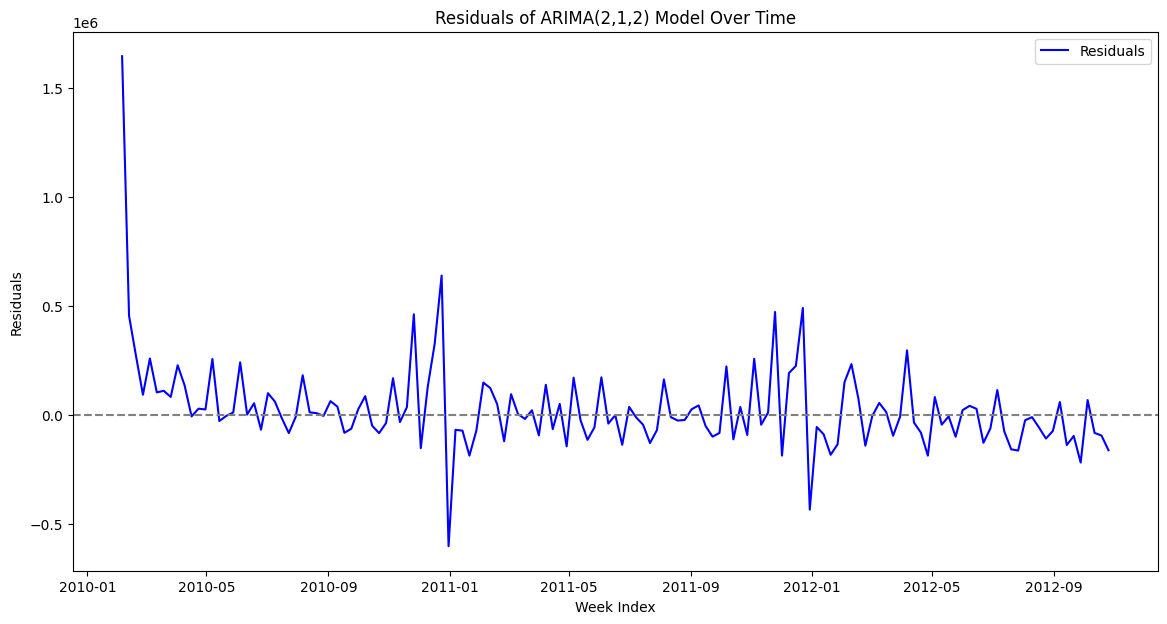

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(ar1_combined_residuals.index, arima_combined_residuals, label='Residuals', color='blue')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Residuals of ARIMA(2,1,2) Model Over Time')
plt.xlabel('Week Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

**11b. Interpret the results from the last answer.**


Answer:  
Still not good

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(train,
                        order=(2, 0, 2),
                        seasonal_order=(1, 1, 1, 52),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
fitted_sarimax = model_sarimax.fit(disp=False)

In [46]:
# Predictions on the training set
train_predictions_sarimax = fitted_sarimax.predict(start=0, end=len(train)-1, typ='levels')

# Predictions on the test set
test_predictions_sarimax = fitted_sarimax.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calculate Mean Squared Error for both training and test sets
mse_train_sarimax = mean_squared_error(train, train_predictions_sarimax)
mse_test_sarimax = mean_squared_error(test, test_predictions_sarimax)

print(f"Training MSE: {mse_train_sarimax}")
print(f"Testing MSE: {mse_test_sarimax}")

Training MSE: 1827605688624.755
Testing MSE: 857434807358.8827


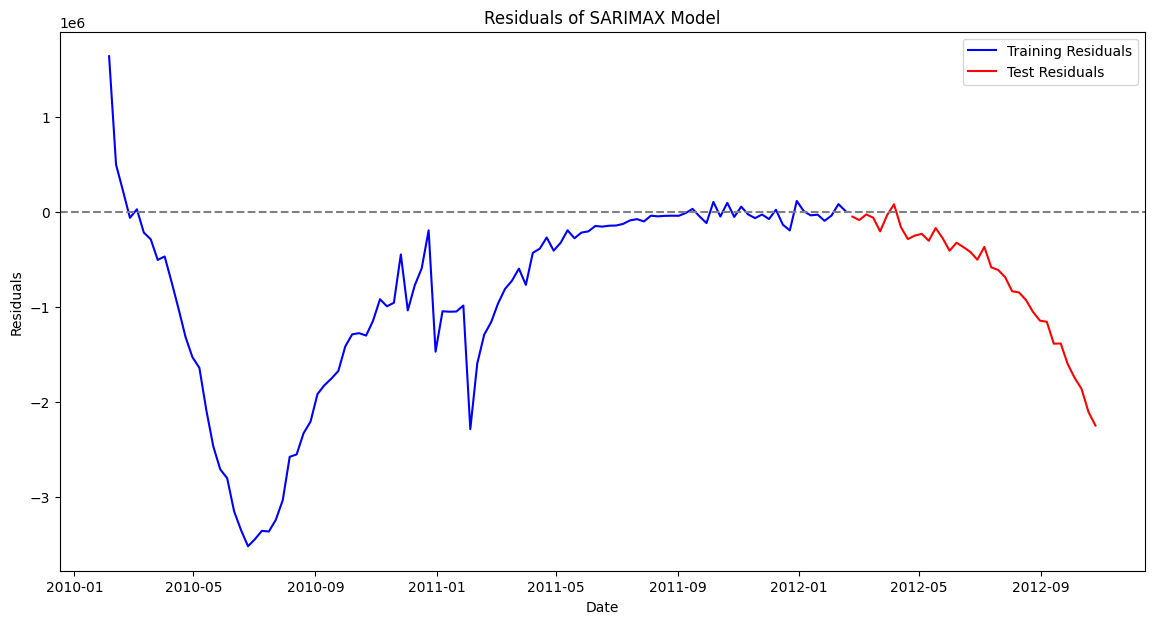

In [47]:
train_residuals_sarimax = train - train_predictions_sarimax
test_residuals_sarimax = test - test_predictions_sarimax

# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(train.index, train_residuals_sarimax, label='Training Residuals', color='blue')
plt.plot(test.index, test_residuals_sarimax, label='Test Residuals', color='red')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Residuals of SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

**12b. How did your best SARIMAX model perform?**

Answer:  
Unstable and getting worse.

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: 

**13c. How might you improve it?**

Answer:  
Using ARIMA gridsearch

In [48]:
sarima_model = pm.AutoARIMA(
                           # same parameters as Auto ARIMA
                           start_p=0, max_p=10, # we specify the start and end for our grid search
                           d=None,    # let Auto ARIMA automatically find optimum value of d automatically
                           start_q=0, max_q=10, # we specify the start and end for our grid search
                           
                           # uncomment these hyperparameter declarations to train SARIMA model this time
                           start_P=0, max_P=10, # tune `P` SARIMA hyperparameter between 0 to 10 same as `p`
                           D=None,    # let Auto ARIMA automatically find optimum value of D automatically
                           start_Q=0, max_Q=10, # tune `Q` SARIMA hyperparameter between 0 to 10 same as `q`
                           m=52, # this is the `S`! Since the peak occurs every 3 months!
                           seasonal=True, # HAS to be set to True to use `m`. goes in conjunction with `m`
                           
                           # same parameters as Auto ARIMA
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

sarima_model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2884.270, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2860.626, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2855.170, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3356.378, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=2877.724, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=2857.068, Time=0.55 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=2852.709, Time=5.62 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=2854.684, Time=7.74 sec
 ARIMA(0,0,1)(0,0,3)[52] intercept   : AIC=2853.510, Time=8.48 sec
 ARIMA(0,0,1)(1,0,3)[52] intercept   : AIC=2855.498, Time=13.72 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=2856.106, Time=5.40 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=2849.586, Time=9.57 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=2852.453, Time=0.47 sec
 ARIMA(1,0,1)(1,0,2)[52] intercept   : AIC=2851.137, Time=21.72 sec
 ARIMA(1,0,1)(0,0

AutoARIMA(m=52, max_P=10, max_Q=10, max_p=10, max_q=10, n_fits=50,
          random_state=20, start_P=0, start_Q=0, start_p=0, start_q=0,
          trace=True)

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(train,
                        order=(1, 0, 0),
                        seasonal_order=(0, 0, 2, 52),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
fitted_sarimax = model_sarimax.fit(disp=False)

In [50]:
# Predictions on the training set
train_predictions_sarimax = fitted_sarimax.predict(start=0, end=len(train)-1, typ='levels')

# Predictions on the test set
test_predictions_sarimax = fitted_sarimax.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calculate Mean Squared Error for both training and test sets
mse_train_sarimax = mean_squared_error(train, train_predictions_sarimax)
mse_test_sarimax = mean_squared_error(test, test_predictions_sarimax)

print(f"Training MSE: {mse_train_sarimax}")
print(f"Testing MSE: {mse_test_sarimax}")

Training MSE: 528055917095.6677
Testing MSE: 1135585367490876.5


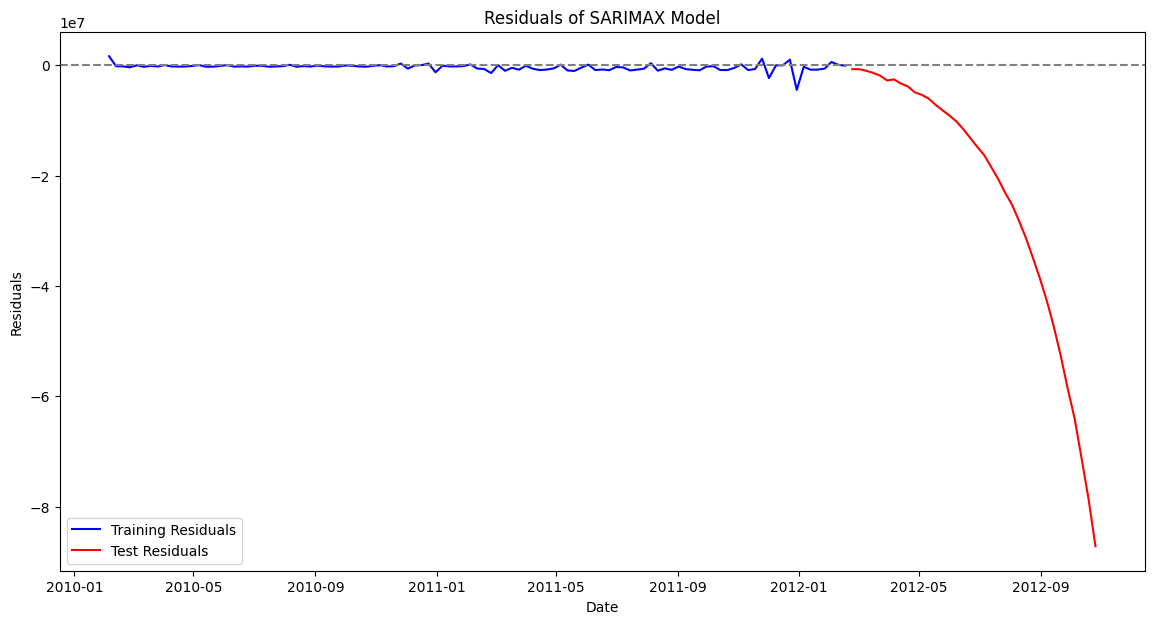

In [51]:
train_residuals_sarimax = train - train_predictions_sarimax
test_residuals_sarimax = test - test_predictions_sarimax

# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(train.index, train_residuals_sarimax, label='Training Residuals', color='blue')
plt.plot(test.index, test_residuals_sarimax, label='Test Residuals', color='red')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Residuals of SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_percentage_error
def plot_forecast(y_train, y_test, arima_model, X_test=None):
    # Generate len(y_test) number of predictions
    y_pred = arima_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')
    
    # Plot data.
    plt.figure(figsize=(30,15))

    # Plot training data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_train, color='blue', label='y_train')

    # Plot testing data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)

    # Plot predicted test values. as shared previously, there are no index in y_pred 
    # so, we need to explicitly pass the `x-axis` (dates) to compare for same timeframe as y_test and access y_pred vs actual y_test
    # we can use y_test.index to get the index of y_test as confirmed earlier in y_test.head()
    plt.plot(y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')
    
    # Find the MAPE (mean abs percentage error) of the predictions
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
    mape = mean_absolute_percentage_error(y_test, y_pred) # like all sklearn metrics we've used, pass y_actual, y_pred

    plt.title(label = f'Sales Predictions\n MAPE: {mape:.2f}', fontsize=16) #\n is just for new line to print MAPE 1 line after header 'Sales Predictions', while .2f rounds MAPE to 2 decimals
    plt.legend(fontsize = 20, loc = 'upper left'); # for legend to be displayed in our plot

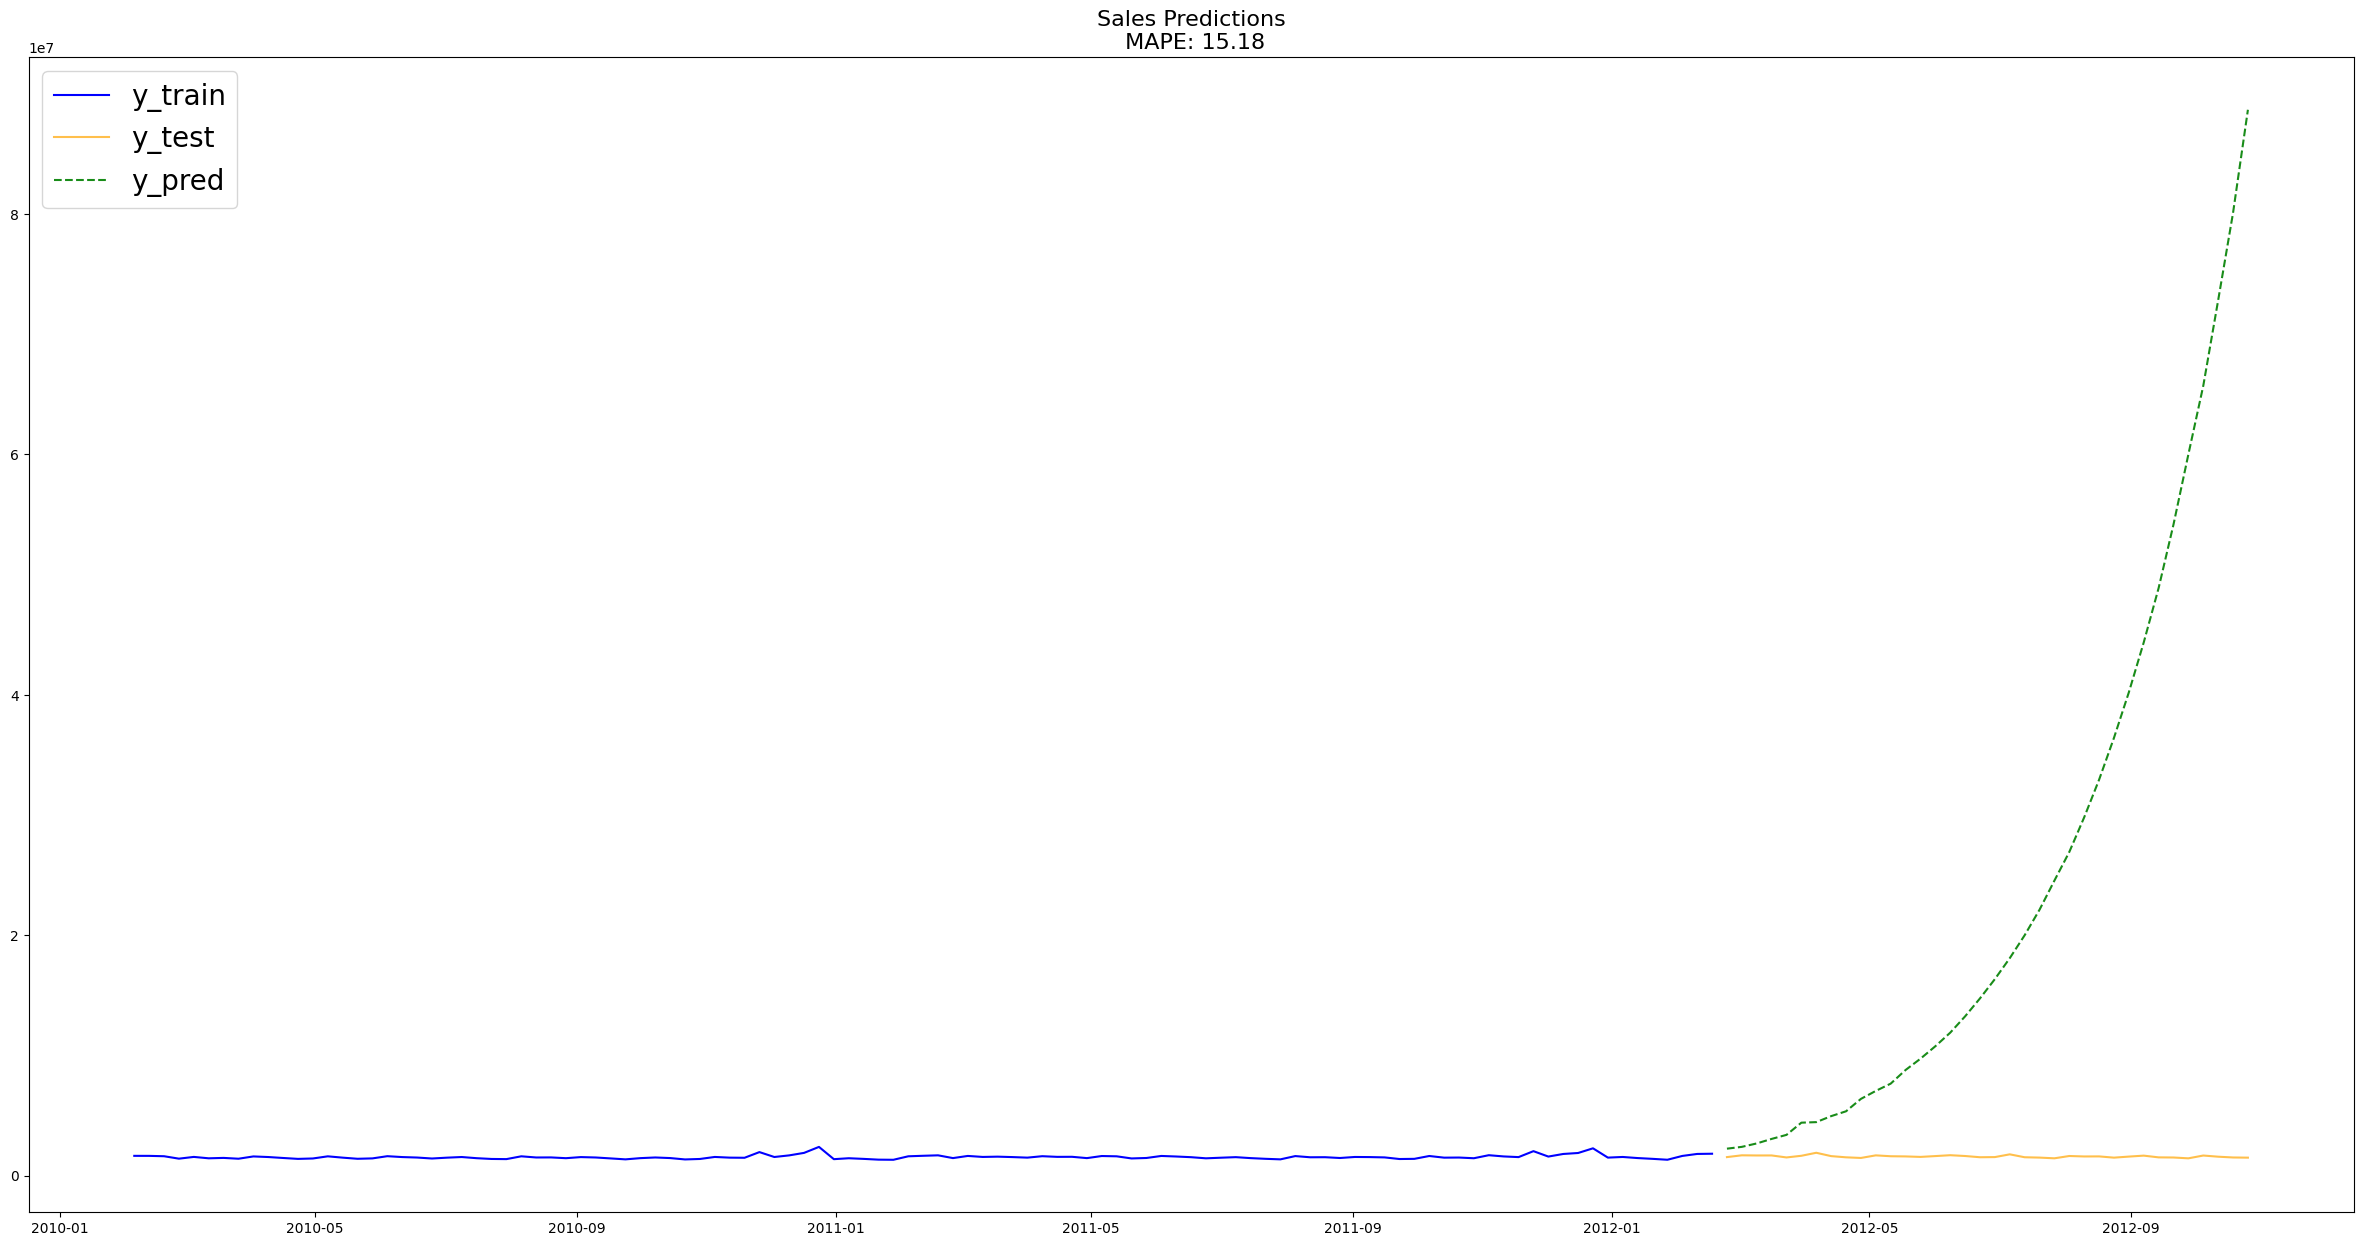

In [53]:
plot_forecast(train, test, fitted_sarimax)

Still bad even after grid search

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: